# 1) Data Exploration

In [3]:
import urllib
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import PIL
import os


from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

2022-11-29 11:43:57.734957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.1) Load Data

- We will use 2 to 3 images of both S1 and S2 satellites to build the model. Right now, the dimensionality of the input and output need to be decided first.
- Data from 1 chip_id "000aa810" is in the 'data' folder from the project.
- It's also important to start working with the metadata .csv files from the project as they will help to track data for training and 
- Data is downloaded from a AWS bucket, best way to get it is by CLI. We need to install AWS CLI in this package

In [4]:
X_data = pd.read_csv('../data/features_metadata - features_metadata.csv')

In [5]:
X_data.loc[1,"s3path_eu"]

's3://drivendata-competition-biomassters-public-eu/train_features/0003d2eb_S1_01.tif'

In [6]:
y_agbm = pd.read_csv(f'../data/train_agbm_metadata.csv')
y_agbm.drop(columns=["s3path_us","s3path_as"],inplace=True)
y_agbm.loc[1,"s3path_eu"]

's3://drivendata-competition-biomassters-public-eu/train_agbm/000aa810_agbm.tif'

In [9]:
y_agbm.head(5)

,filename,chip_id,size,cksum,s3path_eu
0,0003d2eb_agbm.tif,0003d2eb,262482,2036246549,s3://drivendata-competition-biomassters-public...
1,000aa810_agbm.tif,000aa810,262482,2858468457,s3://drivendata-competition-biomassters-public...
2,000d7e33_agbm.tif,000d7e33,262482,277850822,s3://drivendata-competition-biomassters-public...
3,00184691_agbm.tif,00184691,262482,3502312579,s3://drivendata-competition-biomassters-public...
4,001b0634_agbm.tif,001b0634,262482,2397957274,s3://drivendata-competition-biomassters-public...


In [11]:
# Read tif file and get a numpy array 
def image_to_np(path, filename):
  file = os.path.abspath(f'{path}{filename}')
  return tifffile.imread(file)

In [12]:
from sklearn.model_selection import train_test_split

In [32]:
test = image_to_np('../data/train data/' , f"0060c0a5_S1_01.tif")

In [16]:
y = image_to_np('../data/ground truth/' , '0060c0a5_agbm.tif')
precentage = 0.8

XS1 = {}
XS2 = {}

for n in range(0,12):
    XS1[n] = image_to_np('../data/train data/' , f"0060c0a5_S1_{'{0}'.format(str(n).zfill(2))}.tif").flatten()
    XS2[n] = image_to_np('../data/train data/' , f"0060c0a5_S2_{'{0}'.format(str(n).zfill(2))}.tif").flatten()
    
    if n == 0:
        XS1_array = XS1[n]
        XS2_array = XS2[n]
    else:
        XS1_array = np.concatenate([XS1_array,XS1[n]],-1)
        XS2_array = np.concatenate([XS2_array,XS2[n]],-1)

        
XS_scaled = np.concatenate([XS1_array,XS2_array],-1)

# X_train, X_test, y_train, y_test = train_test_split(XS_scaled, y, test_size=0.33)

In [47]:
y.shape

(256, 256)

In [17]:
np.count_nonzero(XS1 == -9999)

0

In [113]:
test.shape

(256, 256, 4)

In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import Input
from tensorflow.keras import layers, Model,Sequential

In [119]:
def build_model(input_layer, start_neurons):
    
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs=[input_layer], outputs = [output_layer])

    return model

input_layer = Input((256, 256,1))
#output_layer = build_model(input_layer, 16)

In [139]:
test = tf.expand_dims(test,axis=0)

In [142]:
y = tf.expand_dims(y,axis=0)

In [183]:
model = build_model(input_layer,16)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 
model.fit(test[:,:,:,0],y)

1/1 [==============================] - 3s 3s/step - loss: 237.5061 - accuracy: 0.2309


In [184]:
predict = model.predict(test[:,:,:,0])

1/1 [==============================] - 0s 405ms/step


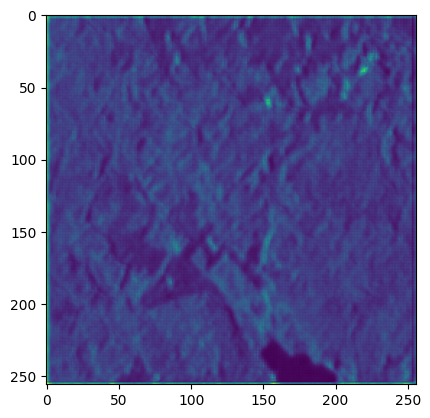

In [185]:
predict_ = tf.squeeze(predict)
plt.imshow(predict_)

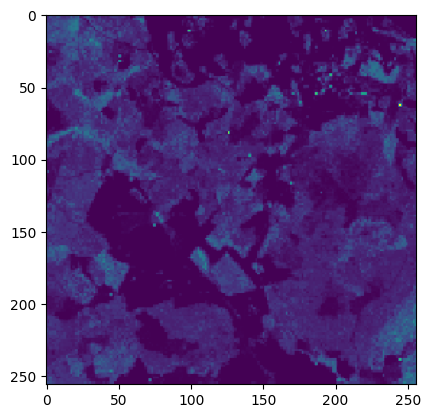

In [186]:
y_ = tf.squeeze(y)
plt.imshow(y_)

In [187]:
model.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_733 (Conv2D)            (None, 256, 256, 16  160         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_734 (Conv2D)            (None, 256, 256, 16  2320        ['conv2d_733[0][0]']             
                                )                                                          

                                                                                                  
 conv2d_747 (Conv2D)            (None, 128, 128, 32  18464       ['dropout_311[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_748 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_747[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_152 (Conv2DTr  (None, 256, 256, 16  4624       ['conv2d_748[0][0]']             
 anspose)                       )                                                                 
                                                                                                  
 concatena

TypeError: unhashable type: 'slice'

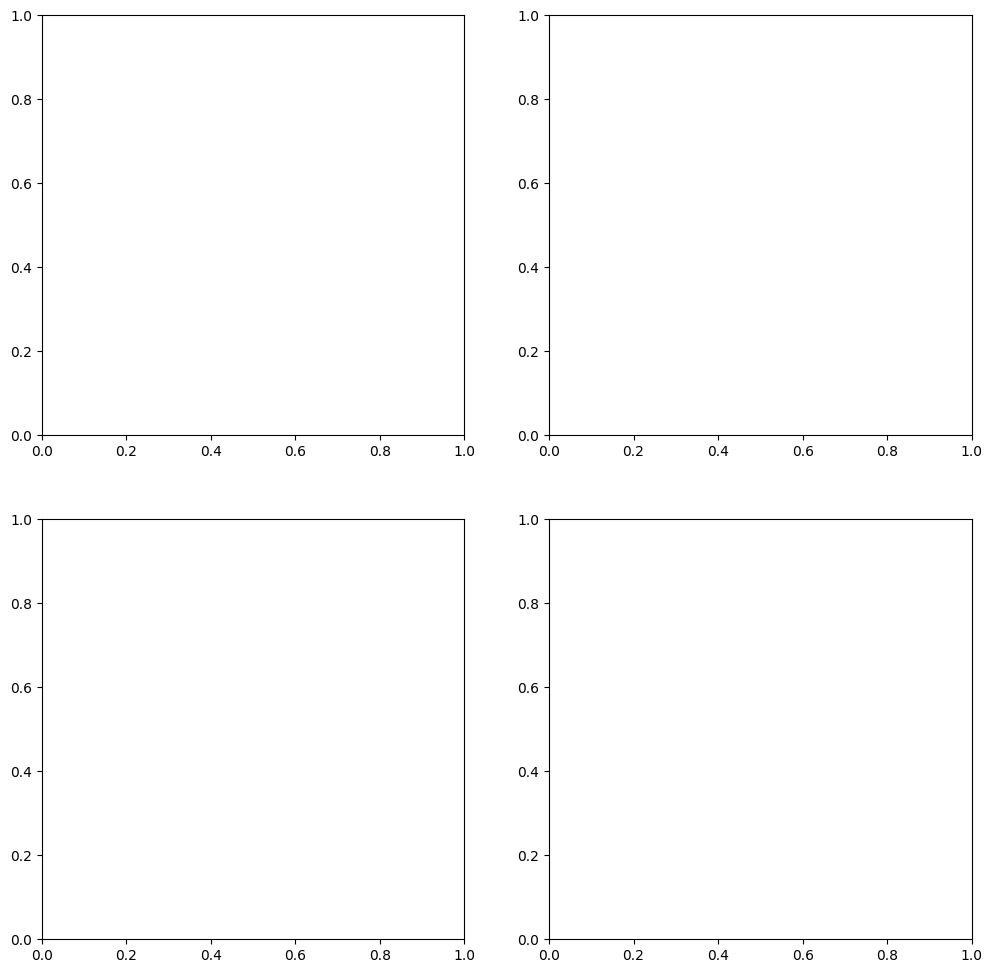

In [148]:
# Function to visualize S1 bands
def S1_view (img):
    _, ax = plt.subplots(2,2, figsize=(12,12))
    ax[0,0].imshow(img[:,:,0]);
    ax[0,0].tick_params(bottom=False, left=False)
    ax[0,1].imshow(img[:,:,1]);
    ax[0,1].tick_params(bottom=False, left=False)
    ax[1,0].imshow(img[:,:,2]);
    ax[1,0].tick_params(bottom=False, left=False)
    ax[1,1].imshow(img[:,:,3]);
    ax[1,1].tick_params(bottom=False, left=False)
    img.shape
    
S1_view(XS1)

In [ ]:
# Function to visualize the 11 bands from S2 images
def S2_image(img):
    axes = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2], 
            [3,0], [3,1]]
    images = list(range(11))
    titles = ['B2-blue','B3-green','B4-red', 'B5-veg red edge 1', 
              'B6-veg red edge 2', 'B7-veg red edge 3', 'B8-NIR', 
              'B8A-Narrow NIR', 'B11-SWIR 1', 'B11-SWIR 2', 'Cloud Prob']

    fig, ax = plt.subplots(4,3, figsize=(14,14))

    for ij, img_num, title in zip(axes, images, titles):
            ax[ij[0],ij[1]].imshow(img [:, :, img_num]);
            ax[ij[0],ij[1]].set_title(title)
            ax[ij[0],ij[1]].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        
    plt.axis('off')
    ax[3,2].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    
S2_image(XS2)
XS2

In [ ]:
# Visualizing LiDAR image
plt.figure(figsize = (8,8))
plt.imshow(y)
plt.xticks([])
plt.yticks([])